### **Customer Churn Prediction Model**

### This script analyzes customer data to predict which users will churn (cancel their service)
within 30 days after being enrolled for 60 days.

### Key Steps:
1. Exploratory Data Analysis (EDA)
2. Data Cleaning and Preparation
3. Feature Engineering
4. Model Building and Evaluation
5. Feature Selection
6. Results Analysis

### 1. Import Libraries and Load Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

### 2. Exploratory Data Analysis (EDA)


In [2]:
# Load dataset
dataset = pd.read_csv('churn_data.csv')

# Initial exploration
print("Dataset shape:", dataset.shape)
print("\nFirst 5 rows:")
print(dataset.head())
print("\nDescriptive statistics:")
print(dataset.describe())

Dataset shape: (27000, 31)

First 5 rows:
    user  churn   age housing  credit_score  deposits  withdrawal  \
0  55409      0  37.0      na           NaN         0           0   
1  23547      0  28.0       R         486.0         0           0   
2  58313      0  35.0       R         561.0        47           2   
3   8095      0  26.0       R         567.0        26           3   
4  61353      1  27.0      na           NaN         0           0   

   purchases_partners  purchases  cc_taken  ...  waiting_4_loan  \
0                   0          0         0  ...               0   
1                   1          0         0  ...               0   
2                  86         47         0  ...               0   
3                  38         25         0  ...               0   
4                   2          0         0  ...               0   

   cancelled_loan  received_loan  rejected_loan  zodiac_sign  \
0               0              0              0          Leo   
1           

### 2.1 Data Cleaning


In [3]:
# Remove invalid credit scores
dataset = dataset[dataset.credit_score >= 300]

# Drop columns with many missing values
dataset = dataset.drop(columns=['credit_score', 'rewards_earned'])

# Check for remaining missing values
print("\nMissing values per column:")
print(dataset.isna().sum())


Missing values per column:
user                       0
churn                      0
age                        0
housing                    0
deposits                   0
withdrawal                 0
purchases_partners         0
purchases                  0
cc_taken                   0
cc_recommended             0
cc_disliked                0
cc_liked                   0
cc_application_begin       0
app_downloaded             0
web_user                   0
app_web_user               0
ios_user                   0
android_user               0
registered_phones          0
payment_type               0
waiting_4_loan             0
cancelled_loan             0
received_loan              0
rejected_loan              0
zodiac_sign                0
left_for_two_month_plus    0
left_for_one_month         0
reward_rate                0
is_referred                0
dtype: int64


### 2.2 Data Visualization


In [4]:
# Separate numerical and categorical features
numerical_cols = dataset.drop(columns=['user', 'churn', 'housing', 'payment_type', 'registered_phones', 'zodiac_sign']).columns
categorical_cols = ['housing', 'is_referred', 'app_downloaded', 'web_user', 'app_web_user', 'ios_user', 'android_user', 'registered_phones', 'payment_type', 'waiting_4_loan', 'cancelled_loan', 'received_loan', 'rejected_loan', 'zodiac_sign', 'left_for_two_month_plus', 'left_for_one_month']

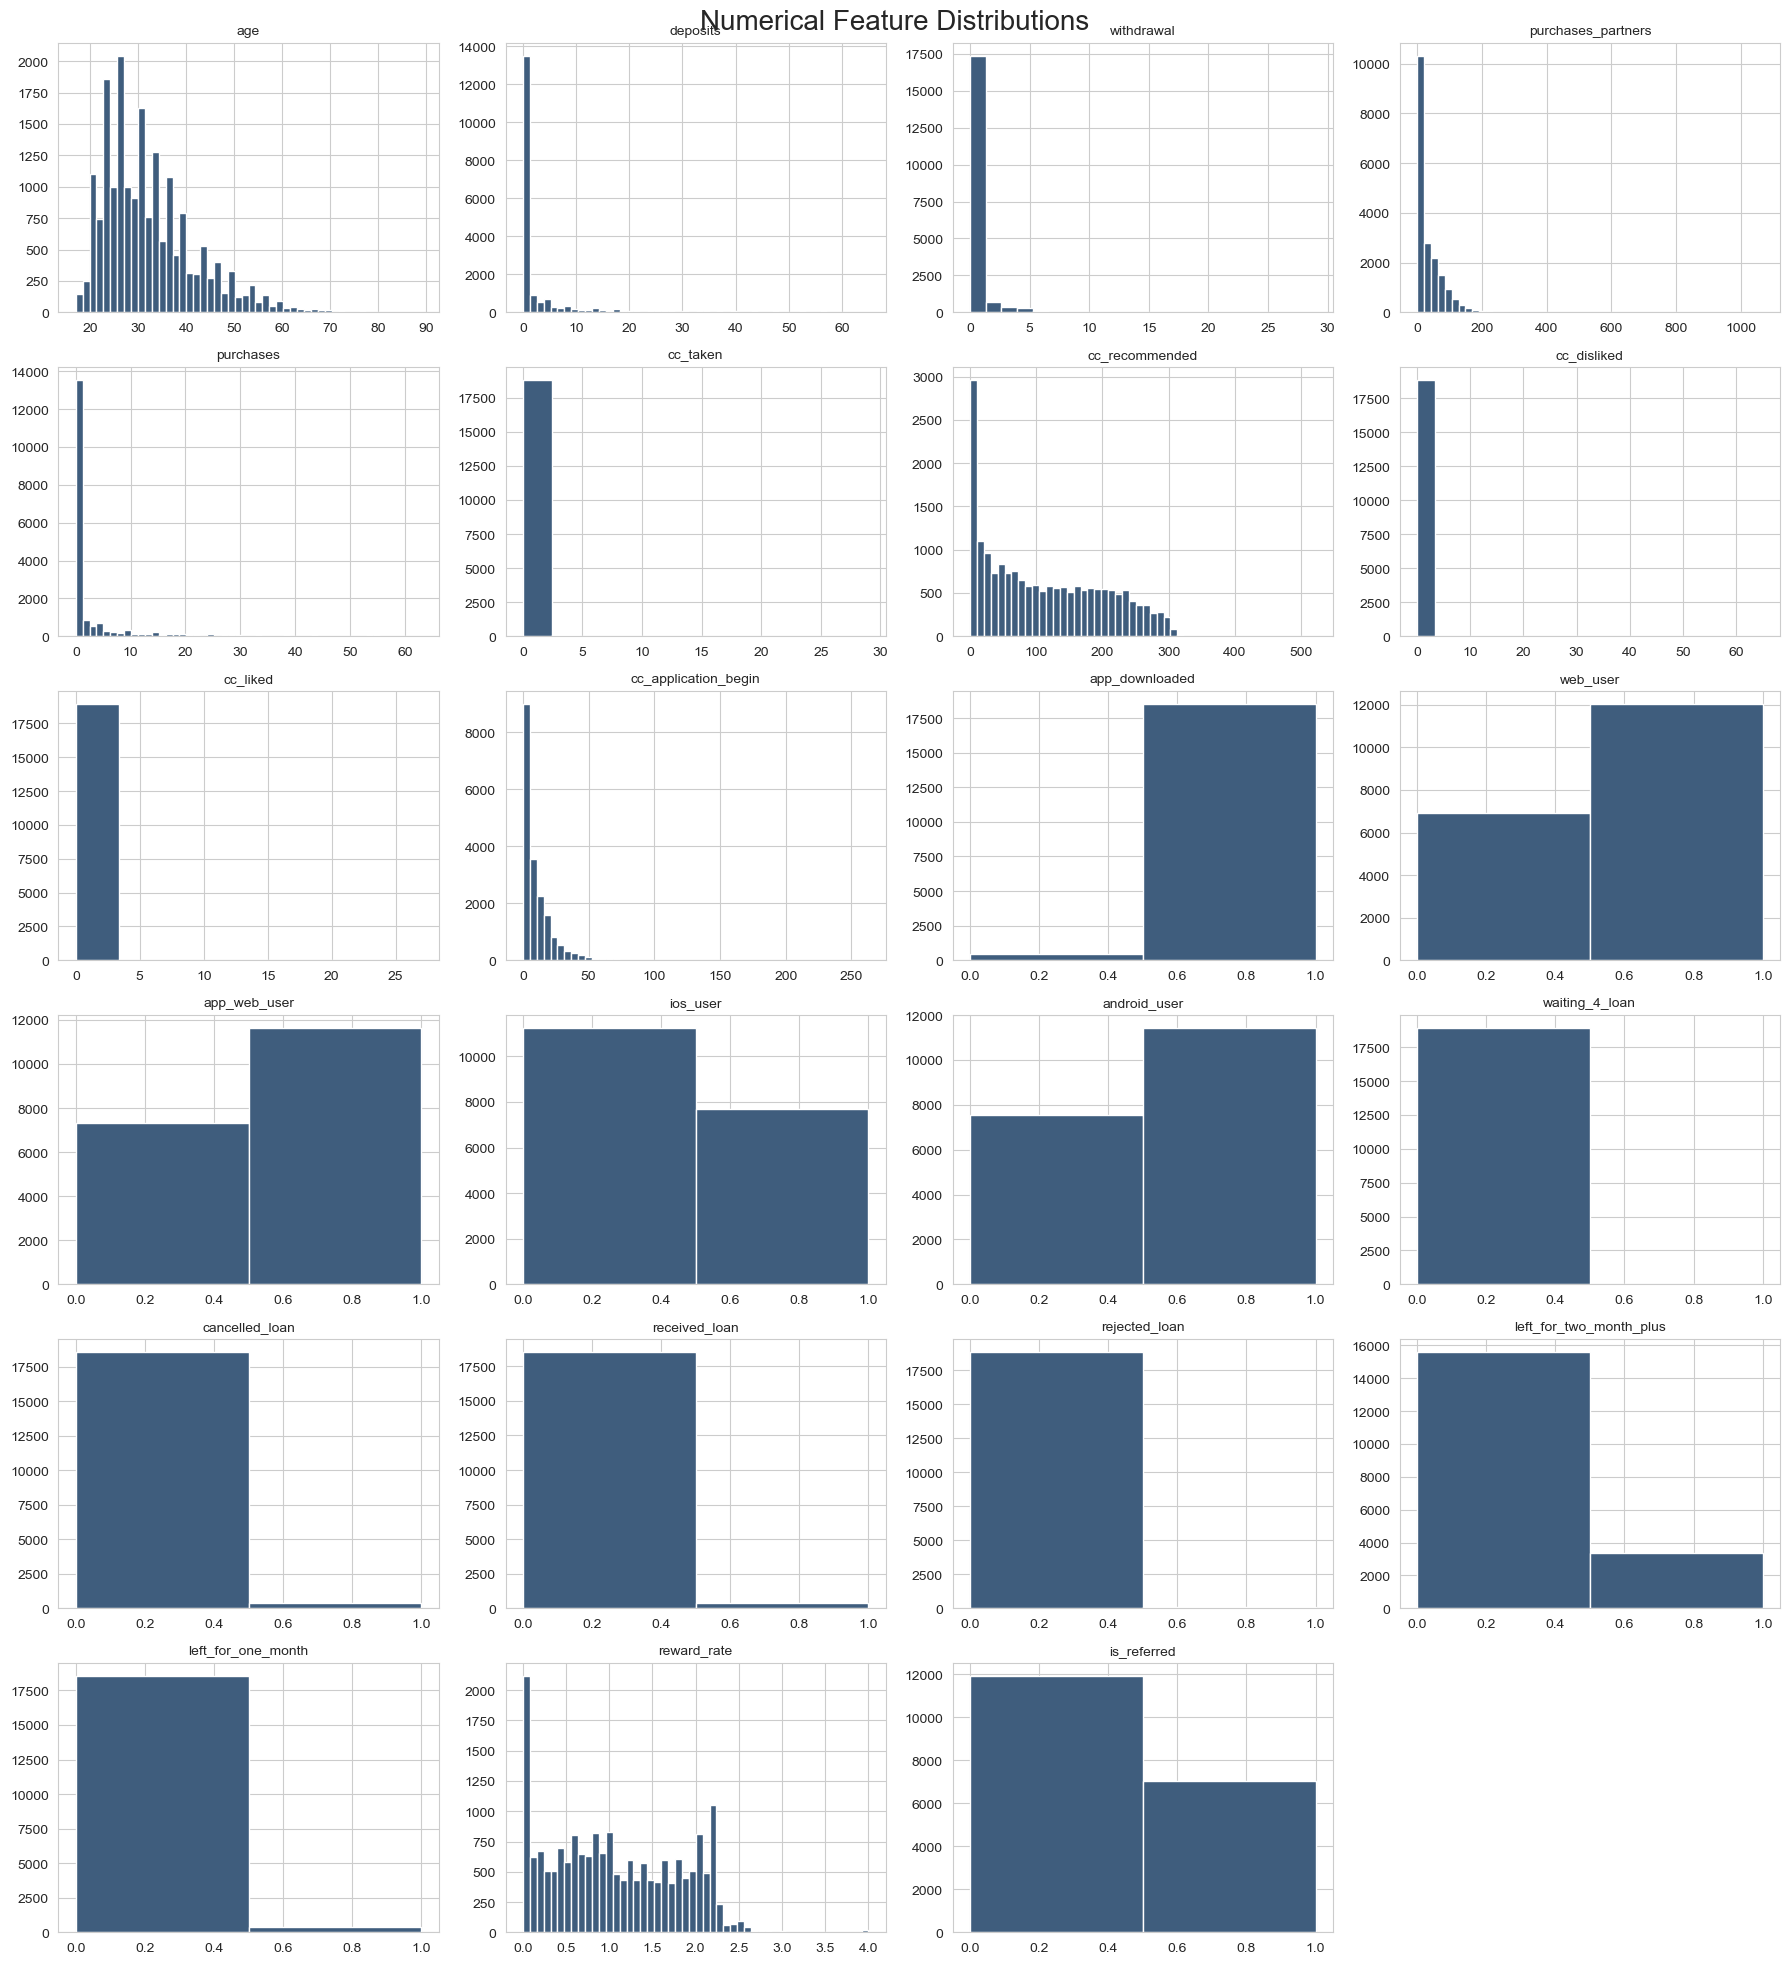

In [5]:
# Histograms for numerical features
plt.figure(figsize=(18, 20))
plt.suptitle('Numerical Feature Distributions', fontsize=20)
for i, col in enumerate(numerical_cols):
    plt.subplot(6, 4, i+1)
    vals = len(dataset[col].unique())
    plt.hist(dataset[col], bins=min(vals, 50), color='#3F5D7D')
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

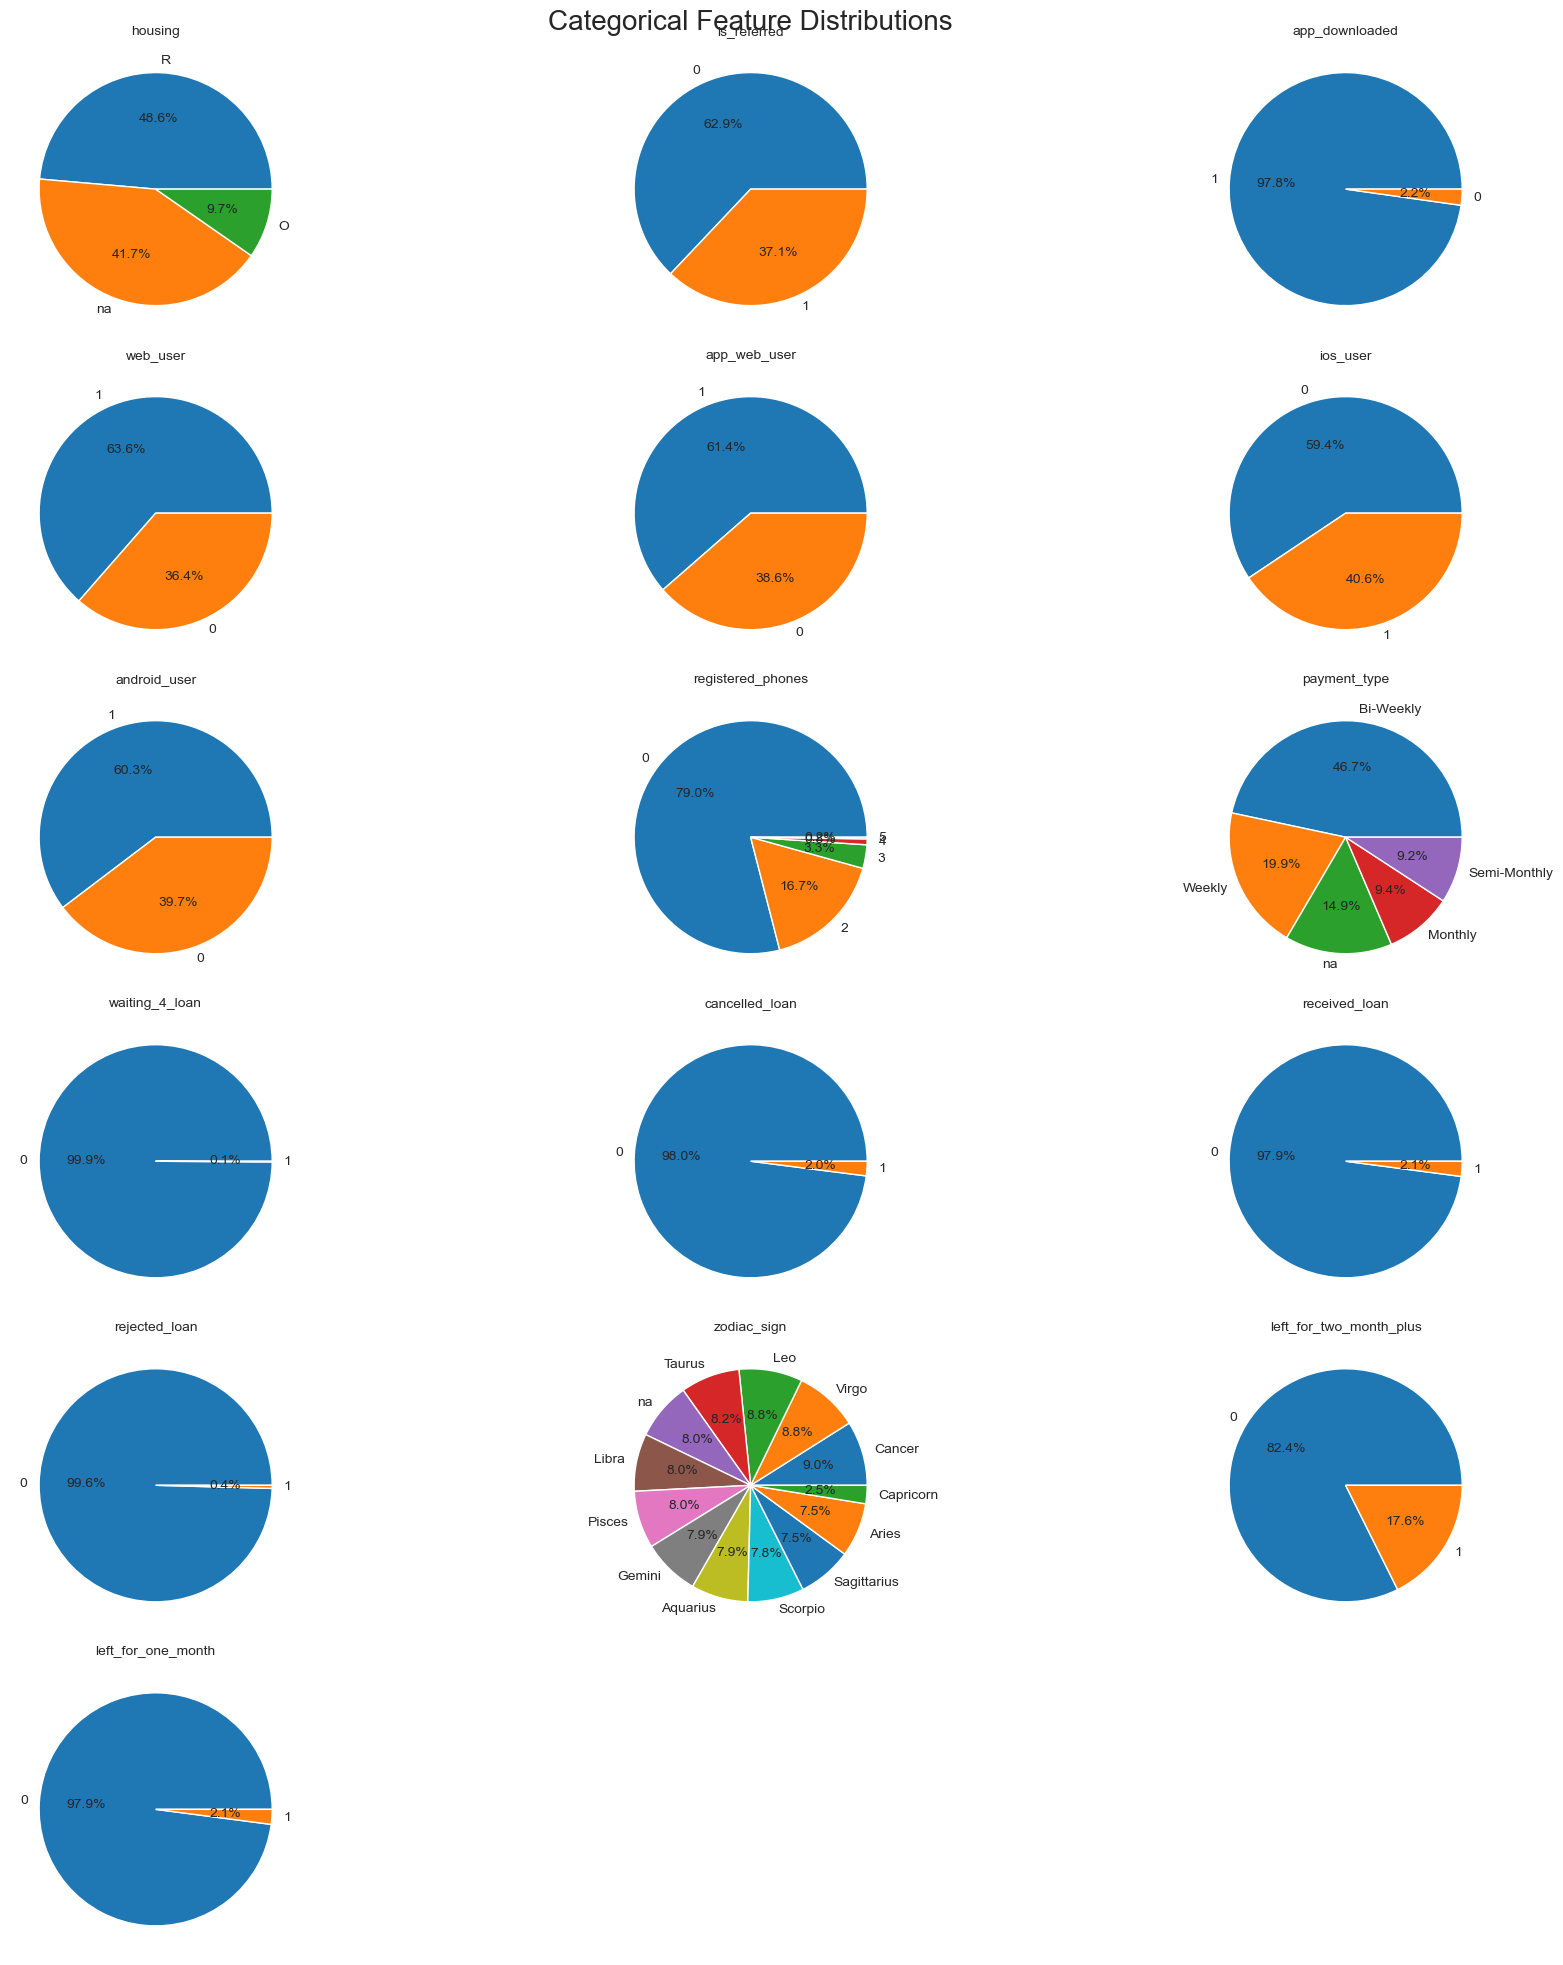

In [6]:
# Pie charts for categorical features
plt.figure(figsize=(18, 20))
plt.suptitle('Categorical Feature Distributions', fontsize=20)
for i, col in enumerate(categorical_cols):
    plt.subplot(6, 3, i+1)
    values = dataset[col].value_counts(normalize=True).values
    labels = dataset[col].value_counts(normalize=True).index
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

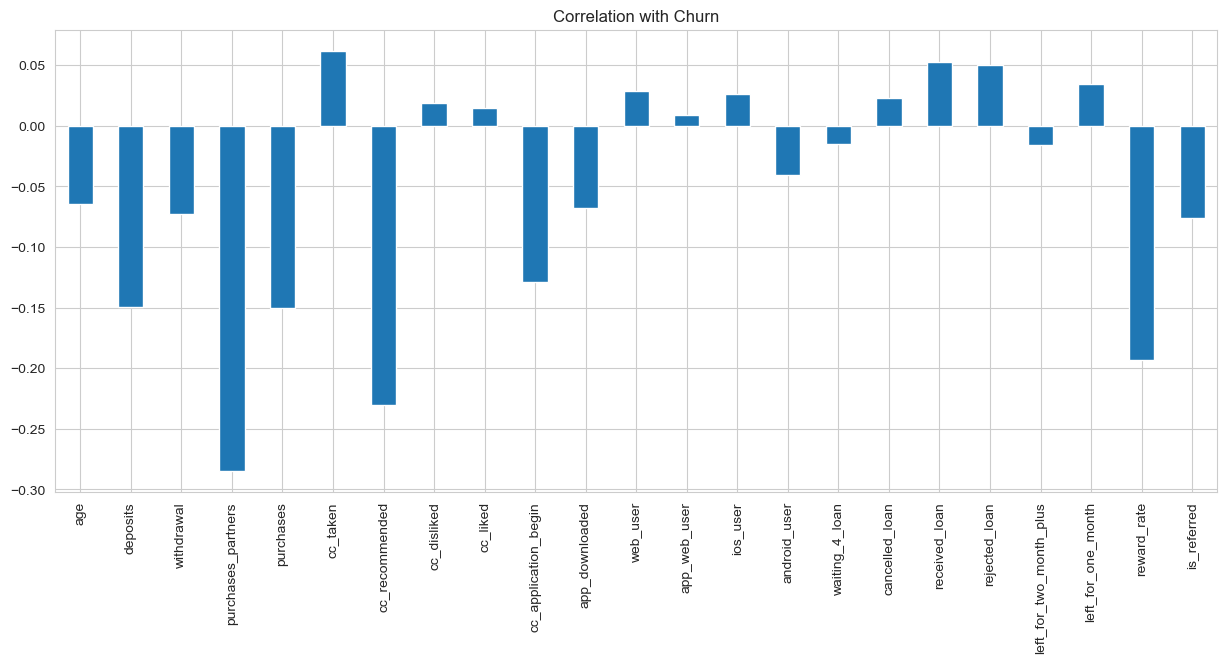

In [7]:
# Correlation with target
corr_with_target = dataset[numerical_cols].corrwith(dataset['churn'])
corr_with_target.plot.bar(figsize=(15, 6), title='Correlation with Churn')
plt.show()

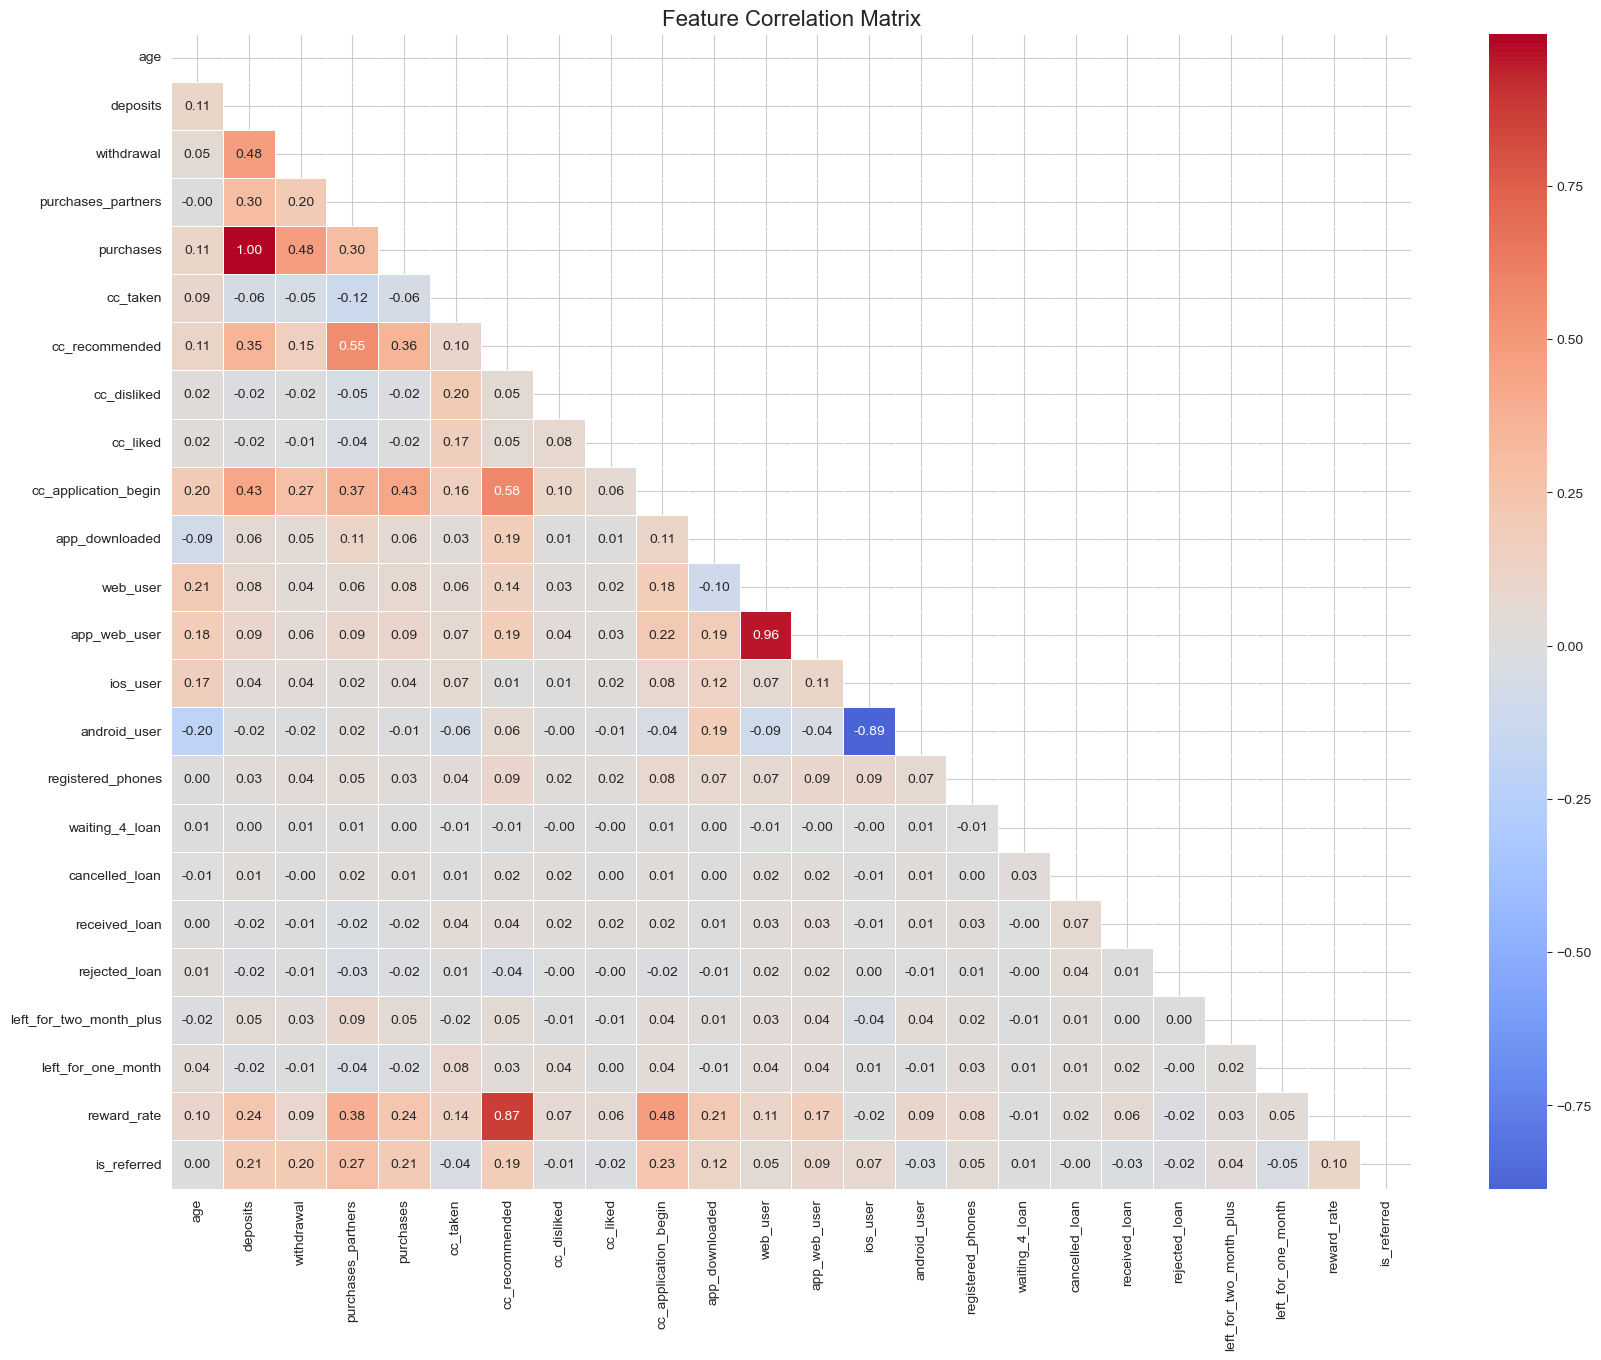

In [9]:
# Correlation matrix heatmap
numeric_cols = dataset.drop(columns=['user', 'churn']).select_dtypes(include=['int64', 'float64']).columns
corr_matrix = dataset[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

### 3. Data Preparation


In [10]:
# Save user identifiers
user_identifier = dataset['user']

# One-hot encode categorical variables
dataset = pd.get_dummies(dataset.drop(columns=['user']), columns=['housing', 'payment_type', 'zodiac_sign'], drop_first=True)

# Split into features and target
X = dataset.drop(columns=['churn'])
y = dataset['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training set
pos_index = y_train[y_train == 1].index
neg_index = y_train[y_train == 0].index
if len(pos_index) > len(neg_index):
    higher, lower = pos_index, neg_index
else:
    higher, lower = neg_index, pos_index
higher = np.random.choice(higher, size=len(lower), replace=False)
new_indexes = np.concatenate((lower, higher))
X_train = X_train.loc[new_indexes]
y_train = y_train[new_indexes]

# Feature scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### 4. Model Building and Evaluation


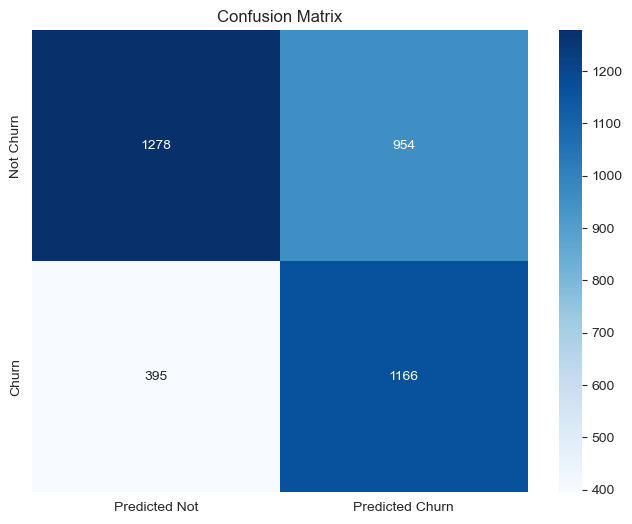

Model Metrics:
Accuracy: 0.6443
Precision: 0.5500
Recall: 0.7470
F1: 0.6335

Cross-Validation Accuracy: 0.6529 (+/- 0.0183)


In [11]:
# Initialize and train model
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm, index=['Not Churn', 'Churn'], columns=['Predicted Not', 'Predicted Churn']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Print results
print("Model Metrics:")
for name, value in metrics.items():
    print(f"{name.title()}: {value:.4f}")
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

### 5. Feature Selection



Selected 20 features:
Index(['age', 'deposits', 'purchases_partners', 'purchases', 'cc_taken',
       'app_downloaded', 'web_user', 'app_web_user', 'ios_user',
       'registered_phones', 'cancelled_loan', 'received_loan', 'rejected_loan',
       'left_for_one_month', 'reward_rate', 'housing_R', 'housing_na',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Pisces'],
      dtype='object')


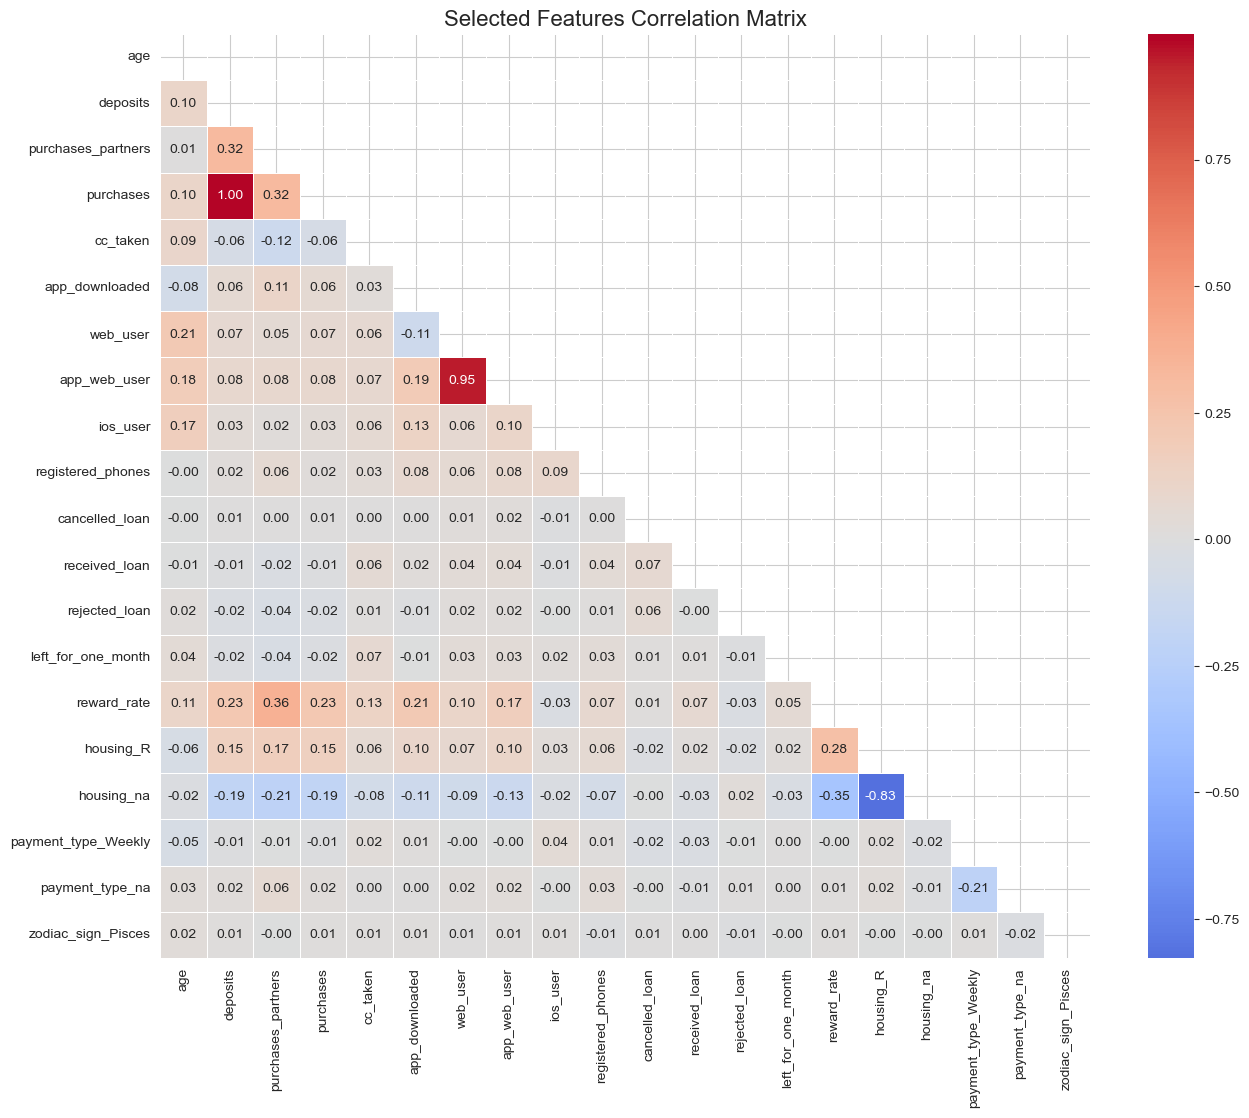

In [12]:
# Perform recursive feature elimination
model = LogisticRegression(random_state=42, solver='liblinear')
rfe = RFE(model, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
print(f"\nSelected {len(selected_features)} features:")
print(selected_features)

# Visualize correlations of selected features
corr_matrix = X_train[selected_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=.5)
plt.title("Selected Features Correlation Matrix", fontsize=16)
plt.show()

### 6. Final Model with Selected Features

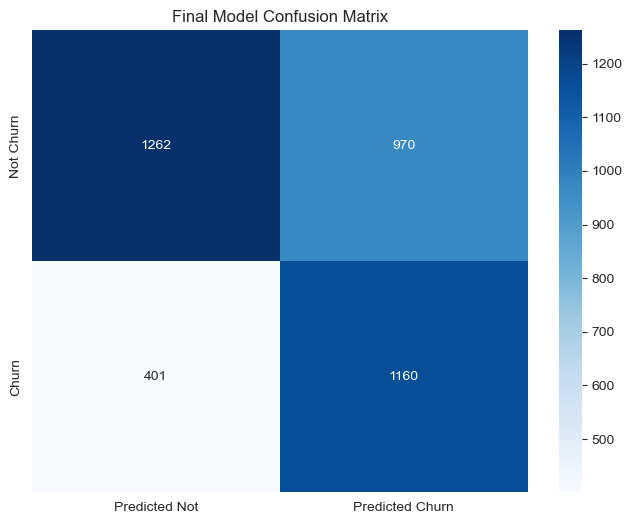


Feature Importance:
                feature  coefficient
7          app_web_user     0.685516
1              deposits     0.217093
17  payment_type_Weekly     0.122520
15            housing_R     0.108503
12        rejected_loan     0.096633
8              ios_user     0.095966
9     registered_phones     0.093953
11        received_loan     0.082773
4              cc_taken     0.073617
16           housing_na     0.063116
18      payment_type_na     0.057825
10       cancelled_loan     0.054390
19   zodiac_sign_Pisces     0.051913
13   left_for_one_month     0.046544
14          reward_rate    -0.187628
0                   age    -0.193952
5        app_downloaded    -0.294558
3             purchases    -0.318034
6              web_user    -0.538835
2    purchases_partners    -0.693330

Final Model Metrics:
Accuracy: 0.6385
Precision: 0.5446
Recall: 0.7431
F1: 0.6286


In [13]:
# Train model on selected features
final_model = LogisticRegression(random_state=42, solver='liblinear')
final_model.fit(X_train[selected_features], y_train)

# Evaluate
y_pred = final_model.predict(X_test[selected_features])
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cm, index=['Not Churn', 'Churn'], columns=['Predicted Not', 'Predicted Churn']), annot=True, fmt='d', cmap='Blues')
plt.title('Final Model Confusion Matrix')
plt.show()

# Feature importance
coefficients = pd.DataFrame({
    'feature': selected_features,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', ascending=False)
print("\nFeature Importance:")
print(coefficients)

# Print final model metrics
print("\nFinal Model Metrics:")
for name, value in metrics.items():
    print(f"{name.title()}: {value:.4f}")

### 7. Results Analysis and Export


In [14]:
# Create results dataframe
results = pd.concat([y_test, user_identifier.loc[y_test.index]], axis=1)
results['predicted_churn'] = final_model.predict(X_test[selected_features])
results['churn_probability'] = final_model.predict_proba(X_test[selected_features])[:, 1]

# Save results
results = results[['user', 'churn', 'predicted_churn', 'churn_probability']]
results.to_csv('churn_predictions.csv', index=False)

# Analyze high-risk customers
high_risk = results[results.churn_probability >= 0.7].sort_values('churn_probability', ascending=False)
print(f"\n{len(high_risk)} high-risk customers identified (probability >= 70%)")


348 high-risk customers identified (probability >= 70%)
